<div class="title">Practical Assignment: Dimensionality Reduction</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author"> XXX </div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard).

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$. We assume it is centered.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size, the examples used will be simple ones. We recommend the use of `eig` from `scipy` for computing the first `n_components` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors found should be flipped in terms of their sign to obtain always the same result.
* Projected data should be centered inside the method (so it has zero mean, but the std remains the same), being careful to also centered the projected new data points. For this purpose you can use the method [KernelCenterer()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KernelCenterer.html) from sklearn.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

In [42]:
import numpy as np
from numpy.linalg import eig
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import KernelCenterer


class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components: int, kernel: str, gamma: float = None):
        """
            Initialization of the KPCA class.

            Parameters:
                - n_components: int, Number of principal components.
                - kernel: str, Kernel type ('linear' or 'rbf').
                - gamma: float or None, Kernel coefficient for 'rbf' kernel.
        """ 
        self.n_components = n_components
        self.kernel = str.lower(kernel)
        self.gamma = gamma
        self.X = None
        self.alphas_ = None
        self.lambdas_ = None

    def _linear_kernel(self, X: np.ndarray, Y: np.ndarray = None):
        return np.dot(X, Y if Y is not None else X.T)
    
    def _rbf_kernel(self, X: np.ndarray, Y: np.ndarray = None):
        if not Y:
            Y = X
        if not self.gamma:
            self.gamma = 1.0 / X.shape[1]

        sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
        return np.exp(-self.gamma * sq_dists)

    def fit(self, X: np.ndarray):
        """
            Fit the KPCA model on the training data X.
            
            Parameters:
            - X: numpy array of shape (n_samples, n_features), Training data.
        """
        self.X = X

        if self.kernel == 'linear':
            K = self._linear_kernel(X)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X)
        else:
            raise ValueError(f"The value of Kernel must be 'linear' or 'rbf', '{self.kernel}' is given")
        
        K = KernelCenterer().fit(K).transform(K)

        eigenvalues, eigenvectors = eig(K)

        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        self.alphas_ = eigenvectors[:, :self.n_components]
        self.lambdas_ = eigenvalues[:self.n_components]


    def transform(self, X: np.ndarray):
        """
            Project new data X into the principal component space.
            
            Parameters:
            - X: numpy array of shape (n_samples, n_features), New data to project.
            
            Returns:
            - Projected data of shape (n_samples, n_components).
        """
        if self.kernel == 'linear':
            K = self._linear_kernel(X)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X)
        else:
            raise ValueError(f"The value of Kernel must be 'linear' or 'rbf', '{self.kernel}' is given")
        
        K = KernelCenterer().fit(K).transform(K)
        
        return np.dot(K, self.alphas_ / np.sqrt(self.lambdas_))

    def fit_transform(self, X: np.ndarray):
        """
            Fit the model to X and then project X into the principal component space.
            
            Parameters:
            - X: numpy array of shape (n_samples, n_features), Training data to fit and project.
            
            Returns:
            - Projected data of shape (n_samples, n_components).
        """
        self.fit(X)
        return self.transform(X)

# Experiments with KPCA

## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

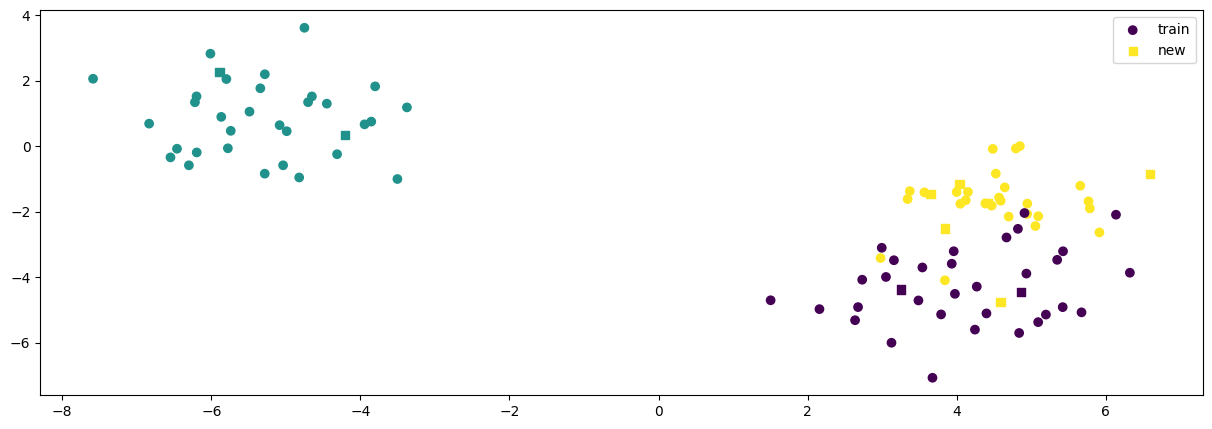

(90, 2)


In [24]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]

plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [43]:
from sklearn.decomposition import PCA

kernel = "linear"
n_components=1

model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = PCA(n_components=n_components)

# Training of the models (complete).
model_sk.fit_transform(X_train)
model_my.fit_transform(X_train)
# Comparative of the eigenvectors (complete).
# ...
print(model_sk.components_)
print(model_my.alphas_)

# Comparative of the projections (complete).
# ...

[[ 0.92260084 -0.38575601]]
[[-0.08123619+0.j]
 [-0.06891148+0.j]
 [ 0.15062412+0.j]
 [-0.04266743+0.j]
 [-0.07147252+0.j]
 [ 0.15780133+0.j]
 [-0.09326465+0.j]
 [-0.04839517+0.j]
 [-0.05374339+0.j]
 [-0.07190818+0.j]
 [ 0.15112781+0.j]
 [-0.05942339+0.j]
 [ 0.19685254+0.j]
 [-0.11713105+0.j]
 [ 0.13009346+0.j]
 [ 0.15464622+0.j]
 [-0.10605742+0.j]
 [-0.0516112 +0.j]
 [-0.06528065+0.j]
 [ 0.12183638+0.j]
 [-0.06478687+0.j]
 [-0.06634531+0.j]
 [-0.04676491+0.j]
 [ 0.114942  +0.j]
 [ 0.1482836 +0.j]
 [ 0.15419275+0.j]
 [ 0.1353215 +0.j]
 [-0.06036211+0.j]
 [ 0.16222287+0.j]
 [-0.05789826+0.j]
 [-0.09784917+0.j]
 [-0.10830916+0.j]
 [-0.07537512+0.j]
 [-0.08553751+0.j]
 [-0.09724484+0.j]
 [ 0.15735876+0.j]
 [ 0.14816689+0.j]
 [-0.07620327+0.j]
 [-0.05962808+0.j]
 [-0.10194315+0.j]
 [ 0.12620459+0.j]
 [ 0.10840434+0.j]
 [ 0.1288974 +0.j]
 [-0.05503203+0.j]
 [-0.05889787+0.j]
 [-0.06739939+0.j]
 [-0.09465508+0.j]
 [ 0.11902141+0.j]
 [-0.07872591+0.j]
 [ 0.14472307+0.j]
 [ 0.15343469+0.j]
 [ 

<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [ ]:
from sklearn.decomposition import KernelPCA

kernel = 'rbf'
n_components=1

# Model definition (complete).
model_my = KPCA(n_components=n_components, kernel=kernel)
model_sk = KernelPCA()

# Training of the models (complete).
# ...

# Comparative of the eigenvectors (complete).
# ...

# Comparative of the projections (complete).
# ...

## Comparing linear kernel against Gaussian kernel

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

In [ ]:
n_components=1

model_linear = KPCA(n_components=n_components, kernel='linear')
model_rbf = KPCA(n_components=n_components, kernel='rbf')